<a href="https://colab.research.google.com/github/apirakqqqqq/GE337_Programming/blob/main/Lab_2/Lab_2_%E0%B8%AD%E0%B8%A0%E0%B8%B4%E0%B8%A3%E0%B8%B1%E0%B8%81%E0%B8%A9%E0%B9%8C_%E0%B8%9B%E0%B8%B1%E0%B8%8D%E0%B8%8D%E0%B8%B2%E0%B8%AA%E0%B8%B2%E0%B8%84%E0%B8%A3_6606614870.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install geopandas rasterio folium shapely matplotlib -q

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**โหลด VECTOR**

In [68]:
import geopandas as gpd

# พื้นที่ศึกษา
aoi = gpd.read_file('/content/Phetburi.geojson')

# จุดสถานี
stations = gpd.read_file('/content/TMD_ALL_Phetburi.geojson')

print(aoi.head())
print(stations.head())
print("CRS AOI:", aoi.crs)
print("CRS Stations:", stations.crs)

   FID  OBJECTID AMPHOE_IDN AMP_CODE         AMPHOE_T  \
0    0       836       7601       01  อ.เมืองเพชรบุรี   
1    1       837       7602       02        อ.เขาย้อย   
2    2       838       7603       03  อ.หนองหญ้าปล้อง   
3    3       839       7604       04           อ.ชะอำ   
4    4       840       7605       05         อ.ท่ายาง   

                   AMPHOE_E PROV_CODE  PROV_NAM_T            PROV_NAM_E  \
0  Amphoe Muang Phetchaburi        76  จ.เพชรบุรี  Changwat Phetchaburi   
1           Amphoe Khao Yoi        76  จ.เพชรบุรี  Changwat Phetchaburi   
2      Amphoe Nong Ya Plong        76  จ.เพชรบุรี  Changwat Phetchaburi   
3             Amphoe Cha Am        76  จ.เพชรบุรี  Changwat Phetchaburi   
4           Amphoe Tha Yang        76  จ.เพชรบุรี  Changwat Phetchaburi   

  P_CODE  ORIG_FID     Shape_Leng    Shape_Area  \
0     PB       765  115387.625015  2.879390e+08   
1     PB       766   95235.221131  3.166559e+08   
2     PB       767  301466.868900  1.225485e+09   
3 

โหลด Raster GeoTiff

In [69]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

raster_path = '/content/phetchaburi_s2_RGB_NIR_SMALL.tif'

src = rasterio.open(raster_path)

print(src.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 5619, 'height': 4456, 'count': 4, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0001796630568239043, 0.0, 99.09854888292914,
       0.0, -0.0001796630568239043, 13.340161632231718), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


**Matplotlib เพรชบุรี**

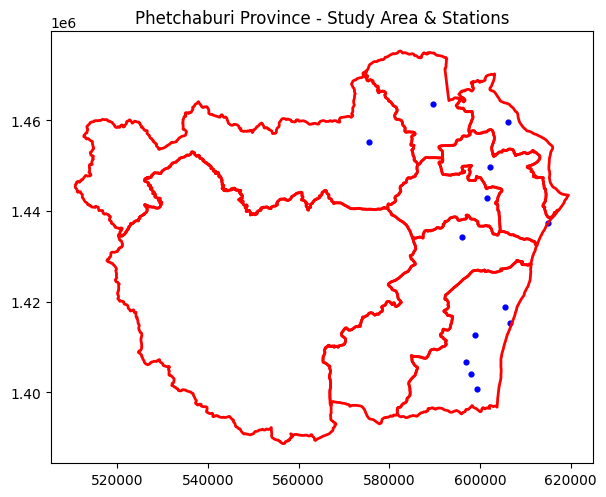

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt

# โหลดข้อมูล
aoi = gpd.read_file('/content/Phetburi.geojson')
stations = gpd.read_file('/content/TMD_ALL_Phetburi.geojson')

# แปลง CRS ให้ตรงกัน (WGS84)
stations = stations.to_crs(aoi.crs)

# plot
fig, ax = plt.subplots(figsize=(7,7))
aoi.boundary.plot(ax=ax, color='red', linewidth=2)
stations.plot(ax=ax, color='blue', markersize=12)

ax.set_title("Phetchaburi Province - Study Area & Stations")
plt.show()

**Folium เพรชบุรี**

In [59]:
import folium

# พิกัดศูนย์กลางจังหวัดเพชรบุรี (ค่าคงที่)
center_lat = 13.1116
center_lon = 99.9447

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,
    tiles='OpenStreetMap'
)

# AOI
folium.GeoJson(aoi, name='AOI').add_to(m)

# Stations
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color='blue',
        fill=True
    ).add_to(m)

m

**แสดง Band**

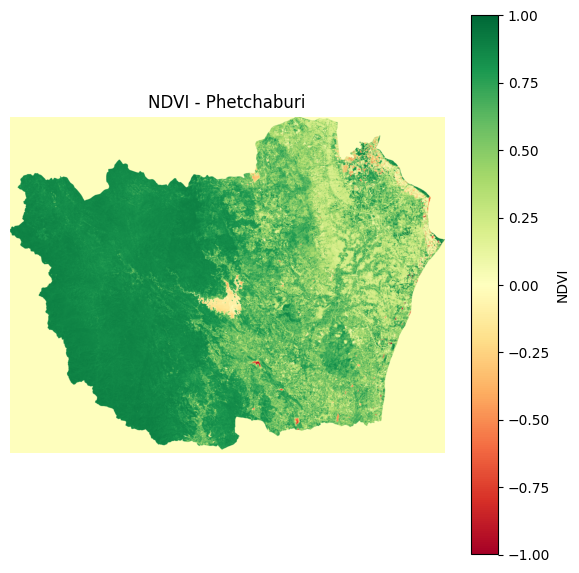

In [79]:
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

# path raster
raster_path = "/content/phetchaburi_s2_RGB_NIR_SMALL.tif"

with rasterio.open(raster_path) as src:

    # ทำ CRS ให้ตรงกับ raster
    aoi = aoi.to_crs(src.crs)

    # clip raster ด้วย polygon
    clipped_img, clipped_transform = mask(src, aoi.geometry, crop=True)

    # แยก band (สมมติ band1=Red, band4=NIR)
    red = clipped_img[0].astype(float)
    nir = clipped_img[3].astype(float)

# คำนวณ NDVI
ndvi = (nir - red) / (nir + red + 1e-10)

# แสดงผล NDVI
plt.figure(figsize=(7,7))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label="NDVI")
plt.title("NDVI - Phetchaburi")
plt.axis("off")
plt.show()

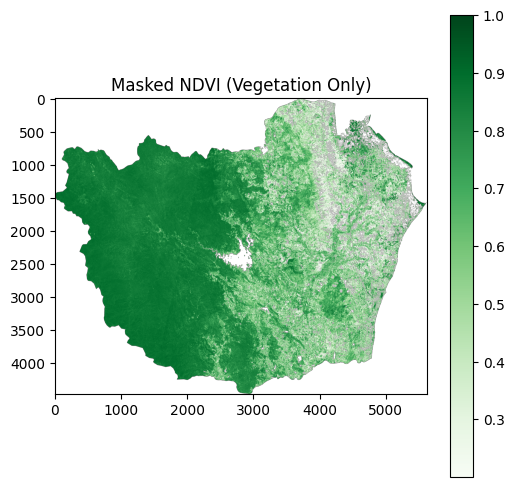

In [73]:
ndvi_masked = np.where(ndvi > 0.2, ndvi, np.nan)

plt.figure(figsize=(6,6))
plt.imshow(ndvi_masked, cmap='Greens')
plt.title("Masked NDVI (Vegetation Only)")
plt.colorbar()
plt.show()

**รวม Vertor + Rasater**

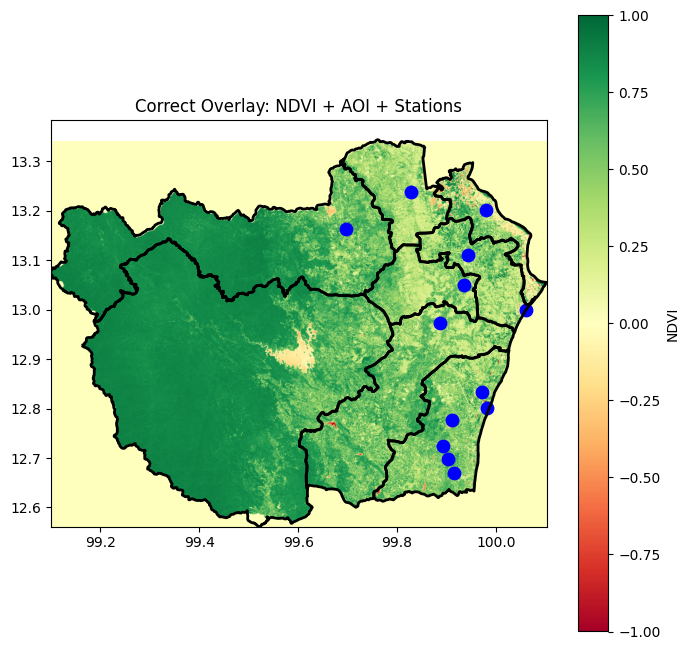

In [83]:
from rasterio.plot import plotting_extent

with rasterio.open("/content/phetchaburi_s2_RGB_NIR_SMALL.tif") as src:
    stations = stations.to_crs(src.crs)
    aoi = aoi.to_crs(src.crs)
    extent = plotting_extent(ndvi, clipped_transform)

fig, ax = plt.subplots(figsize=(8,8))

# ใส่ extent สำคัญมาก
im = ax.imshow(ndvi, cmap='RdYlGn', extent=extent)

aoi.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
stations.plot(ax=ax, color='blue', markersize=80)

plt.colorbar(im, ax=ax, label="NDVI")
ax.set_title("Correct Overlay: NDVI + AOI + Stations")
ax.set_aspect('equal')

plt.show()

**การแสดงผลข้อมูล**

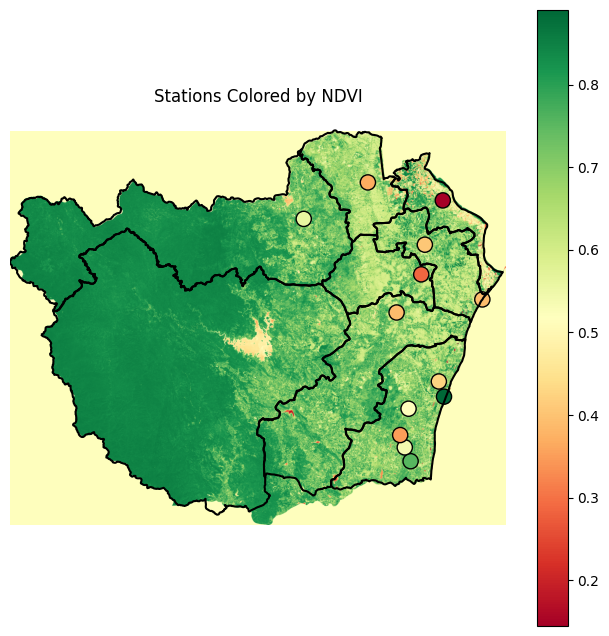

/tmp/ipython-input-2826592509.py:68: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = aoi_wgs.geometry.centroid.iloc[0]


In [92]:

import numpy as np
import matplotlib.pyplot as plt
import folium
from rasterio.plot import plotting_extent

# ----------------------------
# 1) Extract NDVI value at each station
# ----------------------------

# ต้องใช้ transform จากตอน clip raster
stations = stations.to_crs(aoi.crs)

station_ndvi = []

for idx, row in stations.iterrows():
    # แปลงพิกัดเป็น pixel
    col, row_pix = ~clipped_transform * (row.geometry.x, row.geometry.y)
    row_pix = int(row_pix)
    col = int(col)

    if (0 <= row_pix < ndvi.shape[0]) and (0 <= col < ndvi.shape[1]):
        value = ndvi[row_pix, col]
    else:
        value = np.nan

    station_ndvi.append(value)

stations["NDVI"] = station_ndvi


# ----------------------------
# 2) Matplotlib Map (Color by NDVI)
# ----------------------------

extent = plotting_extent(ndvi, clipped_transform)

fig, ax = plt.subplots(figsize=(8,8))

# แสดง NDVI background
im = ax.imshow(ndvi, cmap='RdYlGn', extent=extent)

# plot station โดยใช้ค่า NDVI เป็นสี
stations.plot(
    ax=ax,
    column="NDVI",
    cmap="RdYlGn",
    markersize=120,
    edgecolor="black",
    legend=True
)

aoi.boundary.plot(ax=ax, edgecolor='black')

ax.set_title("Stations Colored by NDVI")
ax.set_aspect('equal')
ax.set_axis_off()

plt.show()


# ----------------------------
# 3) Folium Interactive Map
# ----------------------------

stations_wgs = stations.to_crs(epsg=4326)
aoi_wgs = aoi.to_crs(epsg=4326)

center = aoi_wgs.geometry.centroid.iloc[0]

m = folium.Map(
    location=[center.y, center.x],
    zoom_start=8,
    tiles="Esri.WorldImagery"
)

# function แปลง NDVI เป็นสี
def ndvi_color(value):
    if np.isnan(value):
        return "gray"
    elif value < 0:
        return "red"
    elif value < 0.3:
        return "orange"
    elif value < 0.6:
        return "yellow"
    else:
        return "green"

# เพิ่ม station แบบเปลี่ยนสีตาม NDVI
for idx, row in stations_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color=ndvi_color(row["NDVI"]),
        fill=True,
        fill_color=ndvi_color(row["NDVI"]),
        popup=f"NDVI: {round(row['NDVI'],3)}"
    ).add_to(m)

m

**คำถามท้าย Lab 2**

**1. ข้อดีและข้อเสียของการใช้ Matplotlib และ Folium ในการแสดงผลข้อมูลเชิงพื้นที่คืออะไร?**

**Matplotlib**
ข้อดี : เหมาะกับการวิเคราะห์เชิงสถิติ ควบคุมรูปแบบกราฟได้ละเอียด แสดง raster/geopandas ได้ดี
ข้อเสีย : ไม่เป็น Interactive ซูม/เลื่อนแผนที่ไม่ได้

**Folium** ข้อดี : เป็น Interactive ซูมเข้า-ออกได้ เหมาะกับงานนำเสนอแผนที่

ข้อเสีย : วิเคราะห์เชิงลึกไม่ได้ และจัดการ raster ขนาดใหญ่ไม่สะดวก


**2. ทำไมเราต้องใช้ Masking และ Clipping ในการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียม?**

เพื่อจำกัดข้อมูลให้อยู่เฉพาะพื้นที่ศึกษา ช่วยลดขนาดข้อมูล โฟกัสเฉพาะพื้นที่ที่ต้องการ และ ตัดพื้นนอกขอบเขตที่ต้องการ

**3. ค่า NDVI บ่งบอกถึงอะไร? และสามารถใช้ NDVI ในการวิเคราะห์อะไรได้บ้าง?**

NDVI ใช้วัดความหนาแน่นและสุขภาพของพืชพรรณ สามารถใช้วิเคราะห์สุขภาพพืช ปริมาณพื้นที่สีเขียว การเปลี่ยนแปลงป่าไม้ และภัยแล้ง

**4. การแปลงค่าพิกัด (CRS) มีความสำคัญอย่างไรในการทำงานกับข้อมูลเวกเตอร์และแรสเตอร์?**

CRS ต้องตรงกันเพื่อให้ข้อมูลเวกเตอร์และแรสเตอร์ซ้อนทับกันอย่างถูกต้อง หากไม่ตรงกันจะทำให้ตำแหน่งผิดตำแหน่งและวิเคราะห์คลาดเคลื่อน

**5. หากต้องการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียมในช่วงเวลาต่าง ๆ (Time Series) ควรทำอย่างไร?**

คือการวิเคราะห์ “การเปลี่ยนแปลงตามเวลา” ของข้อมูลภาพถ่ายดาวเทียม เช่น การเปลี่ยนแปลงความเขียวของพืช พื้นที่ป่า หรือความแห้งแล้ง ในช่วงหลายเดือนหรือหลายปี